# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score

from sklearn import metrics

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
# loading Dias Attributes from the 2017 excel list
diasa = pd.read_excel('DIAS Attributes - Values 2017.xlsx', sheet_name = 'Tabelle1', skiprows=[0])

### Data Exploration

In [ ]:
# data shape
azdias.shape

In [ ]:
# data info
azdias.info()

In [ ]:
azdias.describe()

In [ ]:
diasa.shape

In [22]:
diasa.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [39]:
# droping NaN in Attribute
diasa = diasa[~diasa['Attribute'].isnull()]
# getting a list of the attributes elaborated on in the excel file
list_of_dias_attributes = list(diasa['Attribute'])

In [25]:
len(list_of_dias_attributes)

314

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Experimental Data Cleaning

In [31]:
# dropping any column that is in azdias but not explained in DIAS Attributes
azdias = azdias.filter(items=list_of_dias_attributes)
azdias.shape

(891221, 272)

In [ ]:
azdias.head()

First we will look for collumns with unusual volume of NaNs, we will likely want to drop these as they could prove problematic for our kmeans clustering. Looking at the provided excel sheet DIAS Attributes 2017 we also know that -1 is used in some collumns to describe missing data as well so we will replace all instances with NaNs.

In [ ]:
azdias = azdias.replace(-1 , np.nan)

In [ ]:
# assessing missing data in each column
col_nan = 100*azdias.isna().sum()/len(azdias)

In [ ]:
plt.figure()
sns.distplot(col_nan.values, kde=False)
plt.ylabel('Number of columns')
plt.xlabel('% of NaN')
plt.title('Percentage of missing values per column')
plt.show()

Collumns with more than 30% missing data seem the exception and could hurt our clustering. We will drop them. 

In [ ]:
# defining colums to drop
col_nan_drop_threshold = col_nan[col_nan > 30]
high_nan_cols = list(col_nan_drop_threshold.index)
# checking columns to be romoved
len(high_nan_cols)
print(high_nan_cols)

In [ ]:
# dropping high NaN collumns
azdias.drop(high_nan_cols, axis = 1, inplace = True)
azdias.shape

We will also want to have a look at rows with unusually high NaNs and remove those as well. 

In [ ]:
# assessing missing data in each row
row_nan = 100*azdias.isnull().sum(axis=1)/len(azdias.columns)

In [ ]:
plt.figure()
sns.distplot(row_nan.values, kde=False)
plt.ylabel('Number of rows')
plt.xlabel('% of NaN')
plt.title('Percentage of missing values per row')
plt.show()

Dropping Rows with unusually high NaNs (>30%).

In [ ]:
# defining rows to drop
row_nan_drop_threshold = row_nan[row_nan > 30]
high_nan_rows = list(row_nan_drop_threshold.index)
# checking number of rows to be romoved
len(high_nan_rows)

In [ ]:
# dropping high NaN rows
azdias.drop(high_nan_rows, axis = 0, inplace = True)
azdias.shape

In [ ]:
# checking what features remain
pd.set_option('max_columns', 271)
azdias.head()

### 1.2 Feature Selection and Data Cleaning

#### Collumns to drop
I am electing to drop the following collumns since I don't think they will be of much use: 

ALTER_HH (Head of household age probably provides no additional value over Age Category), 

CAMEO_DEU_2015, CAMEO_DEUG_2015, (These features summerize other features and thus provide no additional value)

In [ ]:
features_to_drop = ['ALTER_HH','CAMEO_DEU_2015', 'CAMEO_DEUG_2015']

In [ ]:
azdias.drop(features_to_drop, axis = 1, inplace = True)

In [ ]:
#re-encoding OST_WEST_KZ as numeric variable
azdias['OST_WEST_KZ'] =  azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [ ]:
# saving cleaned data to csv
azdias.to_csv('Cleaned_AZDIAS.csv')

#### Defining the Cleaning Fuction
This cleaning fuction does everything we did step by step above.

In [40]:
#defining the data cleaning fuction
def clean_data(df, f=list_of_dias_attributes, drop_col=True, drop_row=True):
    '''
    Input: Data
    Output: Cleaned Data
    '''
    #dropping any column that is in azdias but not explained in DIAS Attributes.
    df = df.filter(items=f)
    
    #replace -1 with NaN
    df = df.replace(-1 , np.nan)
    #calculating NaN % in columns and dropping those above the threshold
    col_nan = df.isnull().sum()/len(df)
    col_nan_drop_threshold = col_nan[col_nan > 0.3]
    high_nan_cols = list(col_nan_drop_threshold.index)
    df.drop(high_nan_cols, axis = 1, inplace = True)
    
    #calculating NaN % in rows and dropping those above the threshold
    row_nan = df.isnull().sum(axis=1)/len(df.columns)
    row_nan_drop_threshold = row_nan[row_nan > 0.3]
    high_nan_rows = list(row_nan_drop_threshold.index)
    df.drop(high_nan_rows, axis = 0, inplace = True)
    
    #dropping manually rejected features
    features_to_drop = ['ALTER_HH','CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
    df.drop(features_to_drop, axis = 1, inplace = True)
    
    #re-encoding OST_WEST_KZ as numeric variable
    df['OST_WEST_KZ'] =  df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    return df

Cleaning the data and saving it to csv so we do not have to run through the time consuming cleaning process again. 

In [33]:
azdias_cleaned = clean_data(azdias)
azdias_cleaned.shape
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
1,1,2,11.0,0.0,2.0,0.0,6.0,5.0,0,0,...,5,6,1,3.0,0.0,2.0,9.0,4.0,3.0,5
2,3,2,10.0,0.0,1.0,0.0,2.0,3.0,0,0,...,4,3,4,2.0,0.0,1.0,9.0,2.0,3.0,5
3,4,2,1.0,0.0,0.0,0.0,4.0,2.0,0,0,...,5,4,4,1.0,0.0,1.0,9.0,7.0,NaN,3
4,3,1,3.0,0.0,4.0,0.0,2.0,5.0,3,5,...,6,2,7,2.0,0.0,2.0,9.0,3.0,2.0,4
5,1,2,5.0,0.0,1.0,0.0,6.0,2.0,0,0,...,2,6,2,0.0,0.0,2.0,9.0,7.0,6.0,4


In [34]:
azdias_cleaned.to_csv('Cleaned_AZDIAS.csv')

In [35]:
customers_cleaned = clean_data(customers)
customers_cleaned.shape
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,4,1,1.0,0.0,2.0,0.0,3.0,5.0,0,0,...,6,1,6,3.0,0.0,1.0,9.0,7.0,6.0,3
2,4,2,1.0,0.0,1.0,0.0,7.0,2.0,0,0,...,2,1,3,1.0,0.0,2.0,9.0,2.0,6.0,3
3,4,1,0.0,NaN,0.0,0.0,7.0,2.0,0,0,...,6,4,7,0.0,0.0,1.0,9.0,7.0,NaN,1
4,3,1,7.0,0.0,4.0,0.0,3.0,6.0,1,2,...,4,4,5,1.0,0.0,2.0,9.0,3.0,2.0,1
5,3,1,1.0,0.0,2.0,0.0,7.0,4.0,0,0,...,6,4,7,1.0,0.0,2.0,9.0,1.0,6.0,2


In [36]:
customers_cleaned.to_csv('Cleaned_Customers.csv')

### 1.3 Scaling and Dimensionality Reduction

In [2]:
#reading in the cleaned data
azdias_cleaned = pd.read_csv('Cleaned_AZDIAS.csv')
customers_cleaned = pd.read_csv('Cleaned_Customers.csv')

In [20]:
# selecting imputer to replace missing values
Imp = Imputer(missing_values=np.nan, strategy='median')
azdias_imp = pd.DataFrame(Imp.fit_transform(azdias_cleaned.values),
                          columns=azdias_cleaned.columns)
customers_imp = pd.DataFrame(Imp.transform(customers_cleaned.values),
                          columns=customers_cleaned.columns)

In [21]:
azdias_imp.head()

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,1.0,1.0,2.0,11.0,0.0,2.0,0.0,6.0,5.0,0.0,...,5.0,6.0,1.0,3.0,0.0,2.0,9.0,4.0,3.0,5.0
1,2.0,3.0,2.0,10.0,0.0,1.0,0.0,2.0,3.0,0.0,...,4.0,3.0,4.0,2.0,0.0,1.0,9.0,2.0,3.0,5.0
2,3.0,4.0,2.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,...,5.0,4.0,4.0,1.0,0.0,1.0,9.0,7.0,4.0,3.0
3,4.0,3.0,1.0,3.0,0.0,4.0,0.0,2.0,5.0,3.0,...,6.0,2.0,7.0,2.0,0.0,2.0,9.0,3.0,2.0,4.0
4,5.0,1.0,2.0,5.0,0.0,1.0,0.0,6.0,2.0,0.0,...,2.0,6.0,2.0,0.0,0.0,2.0,9.0,7.0,6.0,4.0


In [22]:
customers_imp.head()

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,0.0,4.0,1.0,1.0,0.0,2.0,0.0,3.0,5.0,0.0,...,6.0,1.0,6.0,3.0,0.0,1.0,9.0,7.0,6.0,3.0
1,2.0,4.0,2.0,1.0,0.0,1.0,0.0,7.0,2.0,0.0,...,2.0,1.0,3.0,1.0,0.0,2.0,9.0,2.0,6.0,3.0
2,3.0,4.0,1.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,...,6.0,4.0,7.0,0.0,0.0,1.0,9.0,7.0,4.0,1.0
3,4.0,3.0,1.0,7.0,0.0,4.0,0.0,3.0,6.0,1.0,...,4.0,4.0,5.0,1.0,0.0,2.0,9.0,3.0,2.0,1.0
4,5.0,3.0,1.0,1.0,0.0,2.0,0.0,7.0,4.0,0.0,...,6.0,4.0,7.0,1.0,0.0,2.0,9.0,1.0,6.0,2.0


In [23]:
# appling feature scaling to the general population demographics and customer data

scaler = RobustScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imp.values),
                          columns=azdias_imp.columns)
customers_scaled = pd.DataFrame(scaler.transform(customers_imp.values),
                          columns=customers_imp.columns)

In [24]:
# performing principle components analysis on the scaled data
pca = PCA().fit(azdias_scaled)

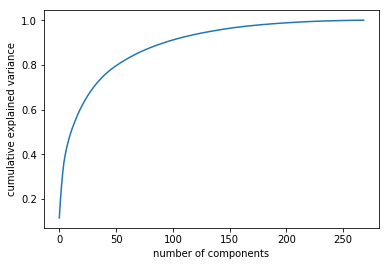

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It appears that 200 components appear to explain close to 100% of the variance in our scaled data.

In [26]:
#re-fitting PCA with selected number of components. 
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.transform(customers_scaled)

### 1.4 K-means Custering

In [27]:
# defining fuction to compute the average intra-cluster distance in kmeans clustered data


def get_kmeans_score(data, c):
    '''
    returns the Sum of Squared Error as a measure of distance from data points to cluster centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiating kmeans
    kmeans = KMeans(n_clusters=c, n_jobs=-1)

    # fitting the model to your data using the fit method
    model = kmeans.fit(data)
    
    # obtaing SSE score related to the fit model
    score = np.abs(model.score(data))
    
    return score

We will iterate over a selection of plausible numbers of clusters and get SSE scores for each. This will allow us to select the number of clusters we actually want to use for our final segmentation. The goal is to select clusters so that all of our target market segment, people similar to our existing customer base, fall into a single cluster, or are at least clearly sperated from the rest of the population.

In [28]:
# initiating an empty list of scores and defining a range of clusters to be investigated
score_list = []
clusters = np.arange(2, 10, 1)

# iterating over a range of clusters from 2 to 10
for c in clusters: 
    score_list.append(get_kmeans_score(azdias_pca, c))

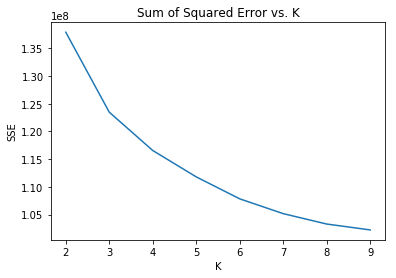

In [30]:
# investigating the change in intra-cluster distance across selected variation of clusters

plt.figure() 
plt.plot(clusters, score_list);
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Sum of Squared Error vs. K')
plt.show()

Selecting 6 clusters seems a solid choice even though no clear 'elbow' is visible in the data. Past 6 SSE reduction becomes marginal.

In [50]:
#fitting the k-means model with selected number of clusters
kmeans = KMeans(n_clusters=6, random_state=42, n_jobs=-1)
azdias_labels = kmeans.fit_predict(azdias_pca)

In [51]:
cluster_count_azdias = pd.Series(azdias_labels).value_counts()

clusters_azdias = pd.DataFrame({'cluster': cluster_count_azdias.index,
                           '% of data': 100*cluster_count_azdias.values/len(azdias_labels)})
clusters_azdias['data'] = 'general population'

# printing clusters_azdias
clusters_azdias

,cluster,% of data,data
0,3,32.949568,general population
1,2,29.139419,general population
2,4,25.386694,general population
3,0,5.385319,general population
4,1,5.350940,general population
5,5,1.788061,general population


In [33]:
#saving data to csv so time intensive clustering does not have to be repeated
clusters_azdias.to_csv('Clusters_AZDIAS.csv')

Generating labels for the existing customers using the K-means model fit to the general population data.

In [52]:
customers_labels = kmeans.predict(customers_pca)

In [53]:
cluster_count_customers = pd.Series(customers_labels).value_counts()

clusters_customers = pd.DataFrame({'cluster': cluster_count_customers.index,
                           '% of data': 100*cluster_count_customers.values/len(customers_labels)})
clusters_customers['data'] = 'customers'

# print cls_azdias
clusters_customers

,cluster,% of data,data
0,3,44.712244,customers
1,4,35.185449,customers
2,2,10.116698,customers
3,1,4.727063,customers
4,0,4.618771,customers
5,5,0.639774,customers


In [36]:
#saving data to csv so time intensive clustering does not have to be repeated
clusters_customers.to_csv('Clusters_Customers.csv')

Comparing general population and customer clustering.

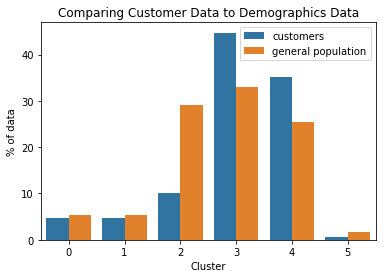

In [54]:
plt.figure()
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([clusters_customers, clusters_azdias]))
plt.xlabel('Cluster')
plt.ylabel('% of data')
plt.title('Comparing Customer Data to Demographics Data')
plt.legend()
plt.show()

### Findings:


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [41]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
# appending RESPONSE to list of dias attributes filter so the column is kept when the cleaning fuction is applied. 
list_of_dias_attributes.append('RESPONSE')

In [43]:
# cleaning training data
mailout_train_cleaned = clean_data(mailout_train)

In [44]:
mailout_train_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP,RESPONSE
0,4,2,15.0,0.0,1.0,0.0,5.0,2.0,0,0,...,1,3,3.0,0.0,2.0,9.0,3.0,6.0,3,0
1,3,2,1.0,0.0,2.0,0.0,5.0,2.0,1,1,...,3,4,2.0,0.0,1.0,9.0,7.0,4.0,1,0
2,4,1,0.0,NaN,0.0,0.0,1.0,4.0,0,1,...,1,7,3.0,0.0,1.0,9.0,2.0,NaN,3,0
3,4,2,4.0,0.0,2.0,0.0,2.0,2.0,0,0,...,3,2,1.0,0.0,2.0,9.0,1.0,6.0,3,0
4,3,1,53.0,0.0,1.0,0.0,4.0,6.0,0,0,...,2,7,1.0,0.0,1.0,9.0,3.0,6.0,3,0


In [45]:
# saving cleaned data to csv
mailout_train_cleaned.to_csv('Mailout_Train_Cleaned.csv')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [46]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
# cleaning test data
mailout_test_cleaned = clean_data(mailout_test)

In [48]:
mailout_test_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,4,1,2.0,0.0,2.0,0.0,6.0,5.0,0,0,...,6,1,7,3.0,0.0,1.0,9.0,3.0,6.0,3
1,4,1,20.0,0.0,1.0,0.0,7.0,1.0,0,0,...,6,1,6,2.0,0.0,1.0,9.0,5.0,6.0,3
2,4,2,2.0,0.0,4.0,0.0,1.0,2.0,0,0,...,4,3,3,3.0,0.0,1.0,9.0,4.0,2.0,3
3,4,2,1.0,0.0,0.0,0.0,1.0,4.0,0,0,...,3,3,2,3.0,0.0,2.0,9.0,2.0,NaN,3
4,4,2,1.0,0.0,4.0,0.0,6.0,6.0,3,4,...,5,3,3,3.0,0.0,1.0,9.0,7.0,3.0,4


In [49]:
# saving cleaned data to csv
mailout_test_cleaned.to_csv('Mailout_Test_Cleaned.csv')